# ECE657AW21 Assignment Iris Dataset
The Iris flower data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper. The data set consists of 50 samples from each of three species of Iris (Iris Setosa, Iris virginica, and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
torch.__version__

'2.8.0+cu126'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class IrisDataSet(Dataset):

    def __init__(self, csv_file, is_test):
        super().__init__()
        self.df = pd.read_csv(csv_file)
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        item = self.df.iloc[index]

        # Return data        
        if self.is_test:
            data = item.iloc[1:].values
            return torch.tensor(data, dtype=torch.float32)
        # Return data, label
        else:
            data = item.iloc[:-1].values
            label = item.iloc[-1]
            return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [5]:
train_dataset = IrisDataSet('./../datasets/iris-train.csv', False)
test_dataset = IrisDataSet('./../datasets/iris-test.csv', True)
train_dataset.df.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.045070,2.508203,3.018024,1.164924,Iris-versicolor
1,6.325517,2.115481,4.542052,1.413651,Iris-versicolor
2,5.257497,3.814303,1.470660,0.395348,Iris-setosa
3,6.675168,3.201700,5.785461,2.362764,Iris-virginica
4,5.595237,2.678166,4.077750,1.369266,Iris-versicolor


In [6]:
train_dataset.df.isna().sum()

sepal_length    0
sepal_width     4
petal_length    8
petal_width     0
species         0
dtype: int64

In [7]:
test_dataset.df.isna().sum()

id              0
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
dtype: int64

In [8]:
train_dataset.df.fillna({'sepal_width': train_dataset.df['sepal_width'].mean(), 'petal_length': train_dataset.df['petal_length'].mean()}, inplace=True)
train_dataset.df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [9]:
feats = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'species'

In [10]:
scaler = StandardScaler()
train_dataset.df[feats] = scaler.fit_transform(train_dataset.df[feats])
test_dataset.df[feats] = scaler.transform(test_dataset.df[feats])
train_dataset.df[feats].head(5)

,sepal_length,sepal_width,petal_length,petal_width
0,-0.949055,-1.240306,-0.463202,-0.044399
1,0.544133,-2.124521,0.425495,0.273083
2,-0.701335,1.700380,-1.365505,-1.026709
3,0.951879,0.321103,1.150555,1.484559
4,-0.307480,-0.857634,0.154749,0.216429


In [11]:
encoder = LabelEncoder()
train_dataset.df[target] = encoder.fit_transform(train_dataset.df[target])
train_dataset.df[target].head(5)

0    1
1    1
2    0
3    2
4    1
Name: species, dtype: int64

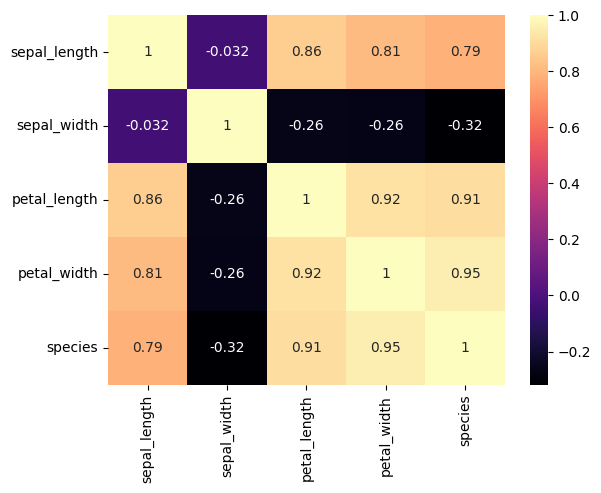

In [12]:
sns.heatmap(train_dataset.df.corr(), annot=True, cmap='magma')
plt.show()

In [13]:
class IrisNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.inLayer = nn.Linear(4, 16)
        self.hidLayer = nn.Linear(16, 16)
        self.outLayer = nn.Linear(16, 3)
        self.relu = nn.ReLU()


        self.linear_layers = nn.Sequential(
            self.inLayer,
            self.relu,
            
            self.hidLayer,
            self.relu,

            self.outLayer
        )
    
    def forward(self, x):
        return self.linear_layers(x)

In [14]:
model = IrisNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [16]:
num_epochs = 25
for epoch in range(num_epochs):
    correct = 0
    n_samples = 0

    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1)
        correct += (labels == pred).sum().item()
        n_samples += len(labels)

    print(f'Epoch {epoch} Accuracy: {correct / n_samples}')

Epoch 0 Accuracy: 0.3238095238095238
Epoch 1 Accuracy: 0.3238095238095238
Epoch 2 Accuracy: 0.34285714285714286
Epoch 3 Accuracy: 0.4666666666666667
Epoch 4 Accuracy: 0.6571428571428571
Epoch 5 Accuracy: 0.7428571428571429
Epoch 6 Accuracy: 0.8095238095238095
Epoch 7 Accuracy: 0.8095238095238095
Epoch 8 Accuracy: 0.819047619047619
Epoch 9 Accuracy: 0.8285714285714286
Epoch 10 Accuracy: 0.8095238095238095
Epoch 11 Accuracy: 0.819047619047619
Epoch 12 Accuracy: 0.819047619047619
Epoch 13 Accuracy: 0.8285714285714286
Epoch 14 Accuracy: 0.8285714285714286
Epoch 15 Accuracy: 0.8285714285714286
Epoch 16 Accuracy: 0.8476190476190476
Epoch 17 Accuracy: 0.8571428571428571
Epoch 18 Accuracy: 0.8571428571428571
Epoch 19 Accuracy: 0.8666666666666667
Epoch 20 Accuracy: 0.8666666666666667
Epoch 21 Accuracy: 0.8571428571428571
Epoch 22 Accuracy: 0.8571428571428571
Epoch 23 Accuracy: 0.8666666666666667
Epoch 24 Accuracy: 0.8761904761904762


In [17]:
model.eval()
predictions = []
n_samples = 0

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        _, pred = torch.max(outputs, 1)
        predictions.extend(pred.cpu().numpy())
        n_samples += len(pred)

predictions = np.array(predictions)

In [18]:
submission_df = pd.DataFrame({'id': range(len(predictions)), 'species': encoder.inverse_transform(predictions)})
submission_df.head(5)

,id,species
0,0,Iris-virginica
1,1,Iris-virginica
2,2,Iris-virginica
3,3,Iris-virginica
4,4,Iris-virginica


In [19]:
submission_df.to_csv('./../submissions/iris-submission.csv', index=False)